In [1]:
# -*- coding: UTF-8 -*-
#%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [2]:
from __future__ import division
import tensorflow as tf
from os import path
import numpy as np
import pandas as pd
import csv
from sklearn.model_selection import StratifiedShuffleSplit
from time import time
from matplotlib import pyplot as plt
import seaborn as sns
from mylibs.jupyter_notebook_helper import show_graph
from tensorflow.contrib import rnn
from tensorflow.contrib import learn
import shutil
from tensorflow.contrib.learn.python.learn import learn_runner
from IPython.display import Image
from IPython.core.display import HTML
from mylibs.tf_helper import getDefaultGPUconfig
from sklearn.metrics import r2_score
from mylibs.py_helper import factors
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from statsmodels.tsa.stattools import coint
from data_providers.price_history_dataset_generator import PriceHistoryDatasetGenerator
from sklearn.linear_model import LinearRegression
from scipy.signal import detrend
from common import get_or_run_nn
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import coint

/home/studenthp/anaconda2/envs/dis/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
dtype = tf.float32
seed = 16011984
random_state = np.random.RandomState(seed=seed)
config = getDefaultGPUconfig()
%matplotlib inline

In [4]:
ph_data_path = '../data/price_history'

In [5]:
npz_full = ph_data_path + '/price_history_dp_60to30_57994.npz'
npz_train = ph_data_path + '/price_history_dp_60to30_57994_train.npz'
npz_train_reduced = ph_data_path + '/price_history_dp_60to30_57994_46400_train.npz'
npz_test = ph_data_path + '/price_history_dp_60to30_57994_11584_test.npz'

In [6]:
#Our batch size is 64 that is why we want train and test size that will be divided exactly by 64
batch_size = 64
train_size = 46400
test_size = 11584
assert train_size % batch_size == 0 and test_size % batch_size == 0

# Generate Train and Test dataset

In [7]:
len(np.load(npz_full)['inputs'])

57994

In [8]:
PriceHistoryDatasetGenerator.train_test_split(fullpath=npz_full, test_size=test_size, train_path=npz_train,
                                              test_path=npz_test, random_state=random_state)

In [9]:
len(np.load(npz_train)['inputs'])

46410

In [10]:
PriceHistoryDatasetGenerator.create_subsampled(inpath=npz_train, target_size=train_size, outpath=npz_train_reduced,
                                              random_state=random_state)

In [11]:
len(np.load(npz_train_reduced)['inputs'])

46400

In [12]:
len(np.load(npz_test)['inputs'])

11584

# Baseline is static, a straight line for each input - Test

In [13]:
npz_path = npz_test

In [14]:
arr = np.load(npz_path)

In [15]:
arr.keys()

['inputs', 'sku_ids', 'sequence_masks', 'targets', 'sequence_lengths']

In [16]:
inputs = arr['inputs']
inputs.shape

(11584, 60, 1)

In [17]:
targets = arr['targets']
targets.shape

(11584, 30)

In [18]:
target_len = targets.shape[1]
target_len

30

In [19]:
preds = np.empty(shape=targets.shape + (1,))
preds.shape

(11584, 30, 1)

In [20]:
#for ii, cur_in in enumerate(inputs):
#    preds[ii] = cur_in[-1]  #broadcasting
#but because we have the targets normed we simply do every prediction zero
preds = np.zeros_like(preds)
preds.shape

(11584, 30, 1)

### evaluate

In [21]:
data_len = len(inputs)
assert len(preds) == len(targets) and data_len == len(targets)

In [22]:
mses = np.empty(data_len)

In [23]:
mses = np.empty(data_len)
for ii, (pred, target) in enumerate(zip(preds, targets)):
    mses[ii] = mean_squared_error(pred, target)

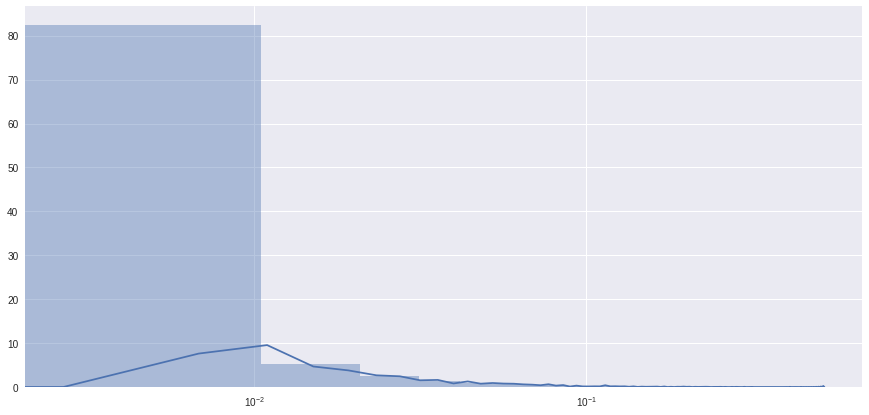

In [24]:
f, ax = plt.subplots(figsize=(15, 7))
ax.set(xscale="log") #, yscale="log")
sns.distplot(mses, ax=ax)
plt.show()

#### MSE loss

In [25]:
np.mean(mses)

0.0073810113363800061

In [26]:
def huber_loss(y_true, y_pred):
    err = y_true - y_pred
    
    absolute = np.abs(err)
    
    ifthen = 0.5 * err
    ifelse = absolute - 0.5
    
    return np.where(absolute < 1.0, ifthen, ifelse)

In [27]:
huber_losses = np.empty(data_len)
for ii, (pred, target) in enumerate(zip(preds, targets)):
    huber_losses[ii] = np.mean(huber_loss(pred, target))

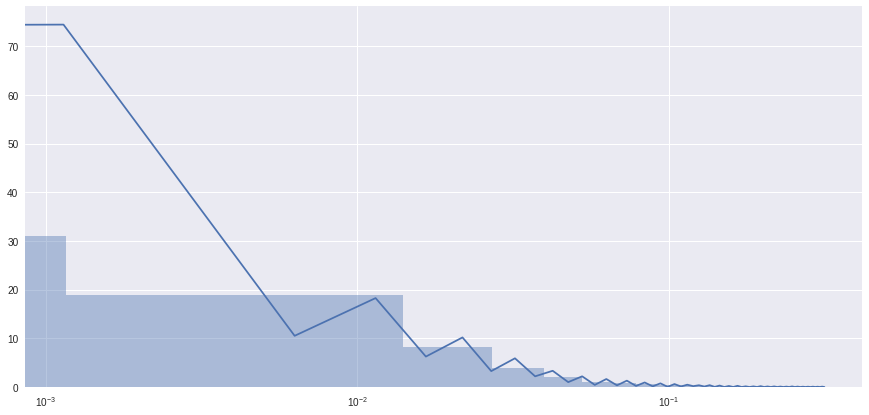

In [28]:
f, ax = plt.subplots(figsize=(15, 7))
ax.set(xscale="log") #, yscale="log")
sns.distplot(huber_losses, ax=ax)
plt.show()

#### Huber Loss

In [29]:
np.mean(huber_losses)

0.0056669112365750956

In [30]:
targets.shape

(11584, 30)

In [31]:
%%time
dtw_scores = [fastdtw(targets[ind], preds[ind])[0]
              for ind in range(len(targets))]

CPU times: user 1min 15s, sys: 292 ms, total: 1min 16s
Wall time: 1min 15s


#### Dynamic Time Warping Mean Score

In [32]:
np.mean(dtw_scores)

1.1494905653937126

In [33]:
coint(preds[0], targets[0])

/home/studenthp/anaconda2/envs/dis/lib/python2.7/site-packages/statsmodels/regression/linear_model.py:1386: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/studenthp/anaconda2/envs/dis/lib/python2.7/site-packages/statsmodels/tsa/stattools.py:1018: UserWarning: y0 and y1 are perfectly colinear.  Cointegration test is not reliable in this case.
  warnings.warn("y0 and y1 are perfectly colinear.  Cointegration test "


(0, 0.98590025802596426, array([-4.31395736, -3.55493606, -3.19393252]))

### plots

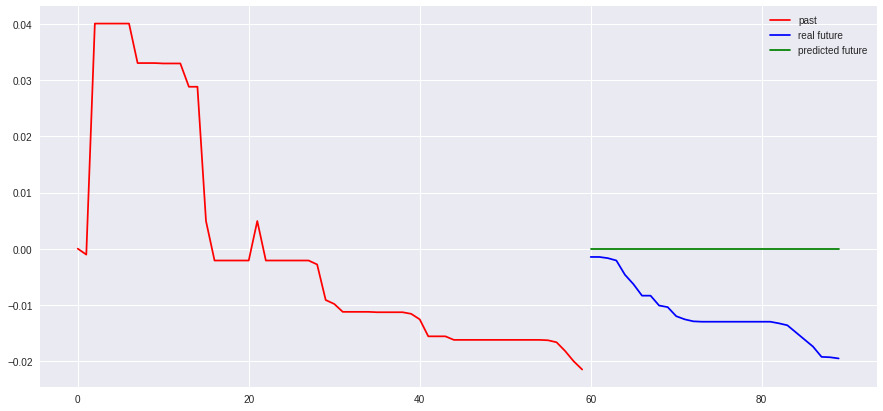

In [34]:
ind = np.random.randint(len(targets))
fig = plt.figure(figsize=(15,7))
plt.plot(range(0,60), inputs[ind].flatten(), 'r')
plt.plot(range(60, 90), targets[ind].flatten(), 'b')
plt.plot(range(60, 90), preds[ind].flatten(), 'g')
plt.legend(['past', 'real future', 'predicted future'])
plt.show()

# Baseline is static, a straight line for each input - Train

In [35]:
npz_path = npz_train_reduced

In [36]:
arr = np.load(npz_path)

In [37]:
arr.keys()

['inputs', 'sku_ids', 'sequence_masks', 'targets', 'sequence_lengths']

In [38]:
inputs = arr['inputs']
inputs.shape

(46400, 60, 1)

In [39]:
targets = arr['targets']
targets.shape

(46400, 30)

In [40]:
target_len = targets.shape[1]
target_len

30

In [41]:
preds = np.empty(shape=targets.shape + (1,))
preds.shape

(46400, 30, 1)

In [42]:
#for ii, cur_in in enumerate(inputs):
#    preds[ii] = cur_in[-1]  #broadcasting
#but because we have the targets normed we simply do every prediction zero
preds = np.zeros_like(preds)
preds.shape

(46400, 30, 1)

### evaluate

In [43]:
data_len = len(inputs)
assert len(preds) == len(targets) and data_len == len(targets)

In [44]:
mses = np.empty(data_len)

In [45]:
mses = np.empty(data_len)
for ii, (pred, target) in enumerate(zip(preds, targets)):
    mses[ii] = mean_squared_error(pred, target)

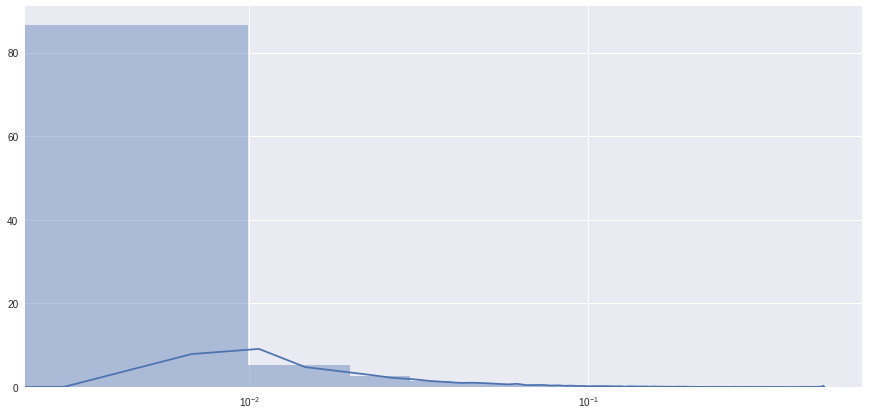

In [46]:
f, ax = plt.subplots(figsize=(15, 7))
ax.set(xscale="log") #, yscale="log")
sns.distplot(mses, ax=ax)
plt.show()

#### MSE loss

In [47]:
np.mean(mses)

0.0073597736641470499

In [48]:
def huber_loss(y_true, y_pred):
    err = y_true - y_pred
    
    absolute = np.abs(err)
    
    ifthen = 0.5 * err
    ifelse = absolute - 0.5
    
    return np.where(absolute < 1.0, ifthen, ifelse)

In [49]:
huber_losses = np.empty(data_len)
for ii, (pred, target) in enumerate(zip(preds, targets)):
    huber_losses[ii] = np.mean(huber_loss(pred, target))

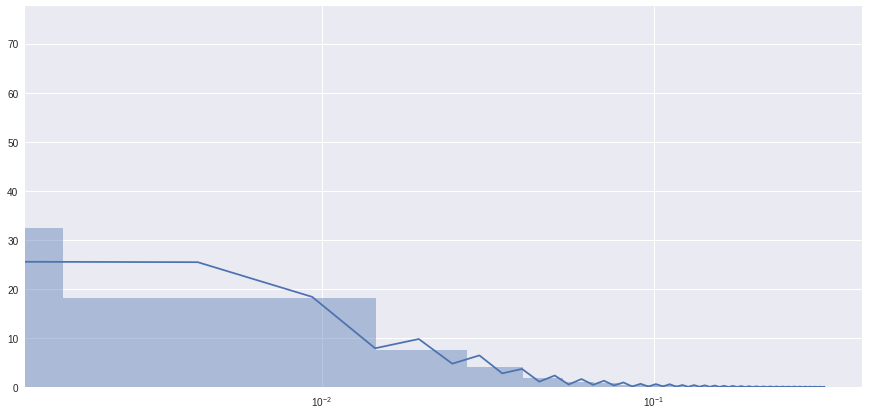

In [50]:
f, ax = plt.subplots(figsize=(15, 7))
ax.set(xscale="log") #, yscale="log")
sns.distplot(huber_losses, ax=ax)
plt.show()

#### Huber Loss

In [51]:
np.mean(huber_losses)

0.0057156383991992417

In [52]:
targets.shape

(46400, 30)

In [53]:
%%time
dtw_scores = [fastdtw(targets[ind], preds[ind])[0]
              for ind in range(len(targets))]

CPU times: user 5min 3s, sys: 1.2 s, total: 5min 4s
Wall time: 5min 3s


#### Dynamic Time Warping Mean Score

In [54]:
np.mean(dtw_scores)

1.1442738505510059

In [55]:
coint(preds[0], targets[0])

(0, 0.98590025802596426, array([-4.31395736, -3.55493606, -3.19393252]))

### plots

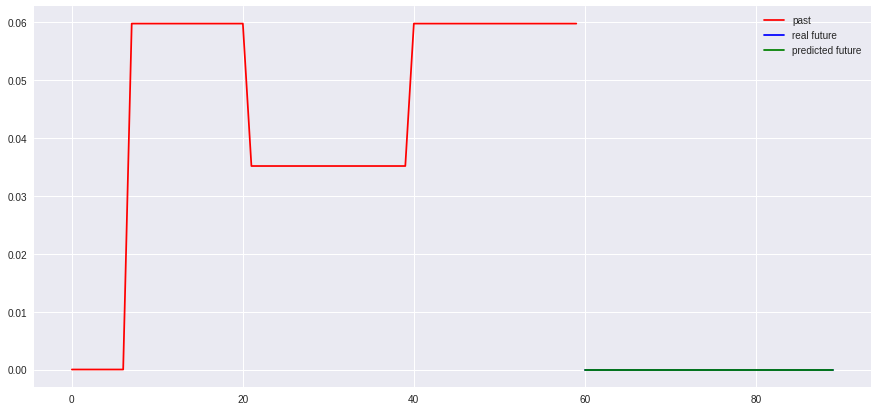

In [58]:
ind = np.random.randint(len(targets))
fig = plt.figure(figsize=(15,7))
plt.plot(range(0,60), inputs[ind].flatten(), 'r')
plt.plot(range(60, 90), targets[ind].flatten(), 'b')
plt.plot(range(60, 90), preds[ind].flatten(), 'g')
plt.legend(['past', 'real future', 'predicted future'])
plt.show()